<a href="https://colab.research.google.com/github/CaP4iK/cretes/blob/main/dl_nlp_ag_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация новостей [AG's News Topic Classification Dataset](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv)

Учебный курс "[Нейросети для анализа текстов](https://www.asozykin.ru/courses/nnpython)".

Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [125]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [126]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

## Загрузка набора данных

Загружаем данные для обучения

In [198]:
!wget https://raw.githubusercontent.com/CaP4iK/cretes/main/dataset.csv -O dataset.csv

--2021-04-18 12:21:49--  https://raw.githubusercontent.com/CaP4iK/cretes/main/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9625 (9.4K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   9.40K  --.-KB/s    in 0s      

2021-04-18 12:21:49 (102 MB/s) - ‘dataset.csv’ saved [9625/9625]



Загружаем данные для тестирования

In [204]:
!wget https://raw.githubusercontent.com/CaP4iK/cretes/main/test.csv -O test.csv

--2021-04-18 12:22:18--  https://raw.githubusercontent.com/CaP4iK/cretes/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 842 [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]     842  --.-KB/s    in 0s      

2021-04-18 12:22:18 (53.7 MB/s) - ‘test.csv’ saved [842/842]



Загружаем имена классов

In [200]:
!wget https://raw.githubusercontent.com/CaP4iK/cretes/main/classes.txt -O classes.txt

--2021-04-18 12:21:58--  https://raw.githubusercontent.com/CaP4iK/cretes/main/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]     126  --.-KB/s    in 0s      

2021-04-18 12:21:58 (6.45 MB/s) - ‘classes.txt’ saved [126/126]



## Просматриваем данные

In [194]:
!ls

best_model_cnn.h5  best_model_lstm.h5  dataset.csv  test.csv
best_model_gru.h5  classes.txt	       sample_data


In [201]:
!cat classes.txt

﻿Дизайн
Нефункц. требования
Взаимодействие пользователя
Структура


In [202]:
!head dataset.csv

﻿Дизайн,"Дизайн страниц выполняется в строгом соответствии с корпоративным стилем компании, с пожеланиями клиента.
Исполнитель предоставляет Заказчику вариант концепции дизайна на примере начальной страницы. После утверждения Исполнитель приступает к выполнению оставшихся страниц."
Дизайн,Стиль оформления произвольный. Количество знаков заголовка и анонса не лимитировано. Заголовок новости является ссылкой. При нажатии на ссылку 
Дизайн,Графическая шапка с горизонтальной навигацией может содержать ненавязчивые флэш-элементы (например, анимированный логотип, являющийся одновременно ссылкой на основную страницу сайта), но не должна отвлекать от информационного наполнения страницы. Желательна разработка нескольких вариантов графической шапки в привязке к основным разделам каталога. Для разделов основной навигации разрабатывается общая шапка.
Дизайн,Внутренняя навигация раздела «Каталог» отображается в виде списка в левой части экрана под шапкой в виде колонки в текстовом виде для последую

In [205]:
!head test.csv

﻿1,Дизайн,Дизайн страниц выполняется в строгом соответствии с корпоративным стилем компании, с пожеланиями клиента.И
2,Нефункц. требования,Сайт разрабатывается под базовое разрешение экрана 800х600 пкс
3,Взаимодействие пользователя,По ссылке на заголовок тура пользователь переходит на страницу с полным описанием конкретного тура. 
4,Структура сайта,«О компании» - содержит краткую информацию раздела со ссылкой «подробнее», ведущую на раздел «О компании».


In [141]:
!wc -l dataset.csv
!wc -l test.csv

32 dataset.csv
4 test.csv


## Загружаем данные в память

Читаем данные из файла

In [135]:
dataset = pd.read_csv('dataset.csv', 
                    header=None, 
                    names=['class', 'text'])

In [142]:
dataset

,class,text
0,1,Дизайн страниц выполняется в строгом соответст...
1,1,Стиль оформления произвольный. Количество знак...
2,1,Графическая шапка с горизонтальной навигацией ...
3,1,Внутренняя навигация раздела «Каталог» отображ...
4,1,В дизайне отдельно предусматриваются ссылки на...
5,1,Между шапкой и контентной областью предполагае...
6,1,Внизу страницы отображается облегченная навига...
7,2,Сайт разрабатывается под базовое разрешение эк...
8,3,По ссылке на заголовок тура пользователь перех...
9,2,Корректное отображение браузерами Internet Exp...


Выделяем данные для обучения

In [143]:
tz = dataset['text']

In [144]:
tz[:5]

0    Дизайн страниц выполняется в строгом соответст...
1    Стиль оформления произвольный. Количество знак...
2    Графическая шапка с горизонтальной навигацией ...
3    Внутренняя навигация раздела «Каталог» отображ...
4    В дизайне отдельно предусматриваются ссылки на...
Name: text, dtype: object

Выделяем правильные ответы

In [145]:
y_tz = utils.to_categorical(dataset['class'] - 1, nb_classes)

In [146]:
y_tz

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

## Токенизация текста

In [147]:
tz[:5]

0    Дизайн страниц выполняется в строгом соответст...
1    Стиль оформления произвольный. Количество знак...
2    Графическая шапка с горизонтальной навигацией ...
3    Внутренняя навигация раздела «Каталог» отображ...
4    В дизайне отдельно предусматриваются ссылки на...
Name: text, dtype: object

Создаем токенизатор Keras

In [148]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на IT Записях

In [149]:
tokenizer.fit_on_texts(tz)

Просматриваем словарь токенизатора

In [150]:
tokenizer.word_index

{'0': 151,
 '4': 150,
 '800х600': 128,
 'aport': 194,
 'arial': 53,
 'courier': 265,
 'explorer': 146,
 'futura': 249,
 'helvetica': 261,
 'internet': 145,
 'mail': 141,
 'navigator': 148,
 'netscape': 147,
 'new': 263,
 'rambler': 195,
 'roman': 264,
 'times': 262,
 'yandex': 193,
 '«баннерная': 119,
 '«визуалов»': 236,
 '«дорого»': 230,
 '«заказать': 137,
 '«интерактив»': 162,
 '«каталог»': 101,
 '«о': 198,
 '«отправить': 48,
 '«подробнее»': 203,
 'активных': 164,
 'анонса': 85,
 'б': 184,
 'базовое': 126,
 'бланк': 174,
 'браузерами': 144,
 'браузеров': 260,
 'быть': 23,
 'в': 1,
 'вариант': 70,
 'вверху': 136,
 'версии': 149,
 'виде': 11,
 'визуальная': 156,
 'визуальное': 163,
 'визуальному': 274,
 'внизу': 43,
 'внутренняя': 99,
 'восприятия': 280,
 'время': 228,
 'выглядеть': 229,
 'выполнению': 78,
 'выполняется': 61,
 'выше': 152,
 'гарнитурами': 244,
 'гарнитуры': 248,
 'горизонтальной': 93,
 'графическая': 91,
 'графических': 52,
 'графическую': 196,
 'групп': 259,
 'группы'

Преобразуем текст в числовое представление

In [151]:
sequences = tokenizer.texts_to_sequences(tz)

Просматриваем новости в числовом представлении

In [152]:
index = 1
print(tz[index])
print(sequences[index])

Стиль оформления произвольный. Количество знаков заголовка и анонса не лимитировано. Заголовок новости является ссылкой. При нажатии на ссылку 
[80, 15, 81, 82, 83, 84, 3, 85, 10, 86, 30, 87, 88, 31, 32, 89, 2, 90]


In [153]:
tokenizer.word_index['цвета']

223

Ограничиваем длину отзывов

In [154]:
x_tz = pad_sequences(sequences, maxlen=max_news_len)

In [155]:
x_tz[:5]

array([[ 27,  61,   1,  62,  63,   5,  64,  65,   6,   5,  66,  67,  28,
         68,  69,  70,  71,  72,   2,  73,  74,   9,  75,  76,  28,  77,
         29,  78,  79,  27],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  80,
         15,  81,  82,  83,  84,   3,  85,  10,  86,  30,  87,  88,  31,
         32,  89,   2,  90],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  91,  92,   5,  93,  94,  33,  95,
         96,  34,  97,  98],
       [  0,   0,   0,   0,  99, 100,  35, 101,  36,   1,  11, 102,   1,
        103, 104,  16,  37,  38,   1,  11, 105,   1,  39,  11,   7, 106,
        107, 108, 109, 110],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,  40, 111,  41,  42,   2,
        112, 113,   3, 114]], dtype=int32)

## Сверточная нейронная сеть

In [156]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(4, activation='softmax'))

In [157]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [158]:
model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 250)           40250     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
Total params: 392,894
Trainable params: 392,894
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [159]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [164]:
history_cnn = model_cnn.fit(x_tz, 
                            y_tz, 
                            epochs=50,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/50
1/1 [==============================] - 0s 73ms/step - loss: 6.7458e-04 - accuracy: 1.0000 - val_loss: 0.6913 - val_accuracy: 0.5000

Epoch 00001: val_accuracy did not improve from 1.00000
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 6.6659e-04 - accuracy: 1.0000 - val_loss: 0.6901 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 1.00000
Epoch 3/50
1/1 [==============================] - 0s 38ms/step - loss: 6.5887e-04 - accuracy: 1.0000 - val_loss: 0.6891 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/50
1/1 [==============================] - 0s 38ms/step - loss: 6.5133e-04 - accuracy: 1.0000 - val_loss: 0.6881 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/50
1/1 [==============================] - 0s 39ms/step - loss: 6.4403e-04 - accuracy: 1.0000 - val_loss: 0.6873 - val_accuracy: 0.5000

Epoch 00005: val_accuracy did not improve from 1.00000
Epoch

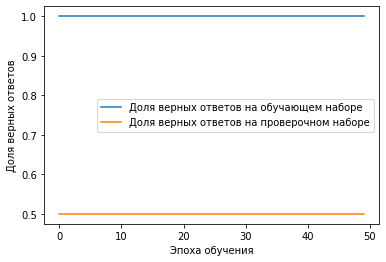

In [165]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [166]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(4, activation='softmax'))

In [167]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [168]:
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
Total params: 323,204
Trainable params: 323,204
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [169]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [170]:
history_lstm = model_lstm.fit(x_tz, 
                              y_tz, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 1.3819 - accuracy: 0.3333 - val_loss: 1.3913 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model_lstm.h5
Epoch 2/5
1/1 [==============================] - 0s 42ms/step - loss: 1.3766 - accuracy: 0.6111 - val_loss: 1.3855 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/5
1/1 [==============================] - 0s 37ms/step - loss: 1.3712 - accuracy: 0.7778 - val_loss: 1.3797 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/5
1/1 [==============================] - 0s 37ms/step - loss: 1.3658 - accuracy: 0.7778 - val_loss: 1.3737 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/5
1/1 [==============================] - 0s 42ms/step - loss: 1.3602 - accuracy: 0.7778 - val_loss: 1.3676 - val_accuracy: 0.5000

Epoch 00005: val_accuracy improved

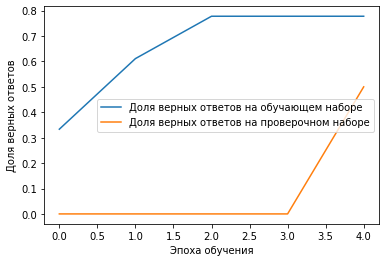

In [171]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [172]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(4, activation='softmax'))

In [173]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [174]:
model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
Total params: 322,468
Trainable params: 322,468
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model_gru.h5`

In [175]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [176]:
history_gru = model_gru.fit(x_tz, 
                              y_tz, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 1.3869 - accuracy: 0.1667 - val_loss: 1.3924 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model_gru.h5
Epoch 2/5
1/1 [==============================] - 0s 40ms/step - loss: 1.3802 - accuracy: 0.3333 - val_loss: 1.3903 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/5
1/1 [==============================] - 0s 35ms/step - loss: 1.3736 - accuracy: 0.5000 - val_loss: 1.3882 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/5
1/1 [==============================] - 0s 35ms/step - loss: 1.3669 - accuracy: 0.6667 - val_loss: 1.3861 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/5
1/1 [==============================] - 0s 36ms/step - loss: 1.3602 - accuracy: 0.6667 - val_loss: 1.3841 - val_accuracy: 0.0000e+00

Epoch 00005: val_accuracy did n

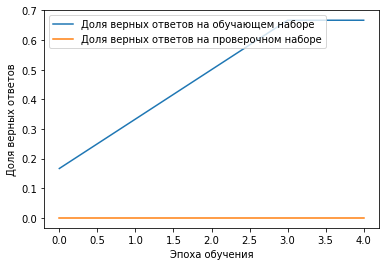

In [177]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [186]:
test = pd.read_csv('test.csv', 
                    header=None, 
                    names=['class', 'title', 'text'])

In [187]:
test

,class,title,text
1,Дизайн,Дизайн страниц выполняется в строгом соответст...,с пожеланиями клиента.Исполнитель предоставля...
2,Нефункц. требования,Сайт разрабатывается под базовое разрешение эк...,NaN
3,Взаимодействие пользователя,По ссылке на заголовок тура пользователь перех...,где он может оформить заявку на выбранный им ...
4,Структура,«О компании» - содержит краткую информацию раз...,ведущую на раздел «О компании».


Преобразуем новости в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [190]:
test_sequences = tokenizer.texts_to_sequences(test['title'+'text'])

KeyError: ignored

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [ ]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 2020, 3371,  449,   15, 6956,  252,   60,   33,
          28,  289,   12, 9088, 2184,  371,  169, 9284],
       [  92,  119,    4, 3472,    8,    1,  402,  134,   75, 5471, 1516,
        1227,    2, 3436,    8, 2744, 5220,  230,  936,   20, 2148,  117,
           1,   38,  561, 1974,    8,   14, 3957, 1218],
       [   2,   52, 5787,   18,    2, 4914,   15,    1,  525,    4, 4586,
         227,    2, 3922,    3, 1316,    2, 6888,    4, 2893,  576,   84,
          33,  758, 6515,    4,    1, 1013, 5154,    4],
       [9642, 1291,    6, 8714,   41,  671,   40, 2977,  177,    1,  108,
          26, 1027, 7300,   26,  760,    5, 3356,   40, 1271, 2450,   26,
        2170,   50, 3356,   26, 7415,    6, 9153,   26],
       [   0,    0,    0,    0,    0,    0,   39,  493, 7343,  832,  400,
         820,   28, 3827,    4,    1, 4474,   54, 9411,    1, 1273,   38,
        1230,    3, 1365,  348, 

Правильные ответы

In [ ]:
y_test = utils.to_categorical(test['class'] - 1, nb_classes)

In [ ]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть 

In [ ]:
model_cnn.load_weights(model_cnn_save_path)

In [ ]:
model_cnn.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 2ms/step - loss: 0.3241 - accuracy: 0.8891


[0.32407426834106445, 0.8890789747238159]

### Сеть LSTM

In [ ]:
model_lstm.load_weights(model_lstm_save_path)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 3ms/step - loss: 0.3240 - accuracy: 0.8916


[0.32402247190475464, 0.8915789723396301]

### Сеть GRU

In [ ]:
model_gru.load_weights(model_gru_save_path)

In [ ]:
model_gru.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 3ms/step - loss: 0.3164 - accuracy: 0.8957


[0.31637880206108093, 0.8956578969955444]

## Полезные ссылки

1. [Определение тональности текстов отзывов на сайте YELP одномерной сверточной нейросетью](https://colab.research.google.com/drive/1KWS-4MKKOIG7UhiCA58ZJcxwSLG5F6Wm).
2. [Определение тональности текстов отзывов на сайте YELP сетью LSTM](https://colab.research.google.com/drive/19olgYyZ4N5fh8RIPtHxkso2N5HD1yg0X).
3. [Использование командной строки Linux в Colab](https://colab.research.google.com/drive/1vFGZ2nDS0ukNGXPL-0avK097afYQILyq).